## Work
1. 試比較有 BN 在 Batch_size = 2, 16, 32, 128, 256 下的差異
2. 請嘗試將 BN 放在 Activation 之前，並比較訓練結果
3. 請於 BN 放在 Input Layer 後，並比較結果

In [1]:
import os
import keras
import itertools
# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [18]:
train, test = keras.datasets.cifar10.load_data()

In [19]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [20]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [24]:
from keras.layers import BatchNormalization
from keras.layers import Dropout
"""
建立神經網路，並加入 BN layer
"""
def build_mlp1(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units,  
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)   
            x = keras.layers.Activation(activation='relu')(x)
            x = Dropout(0.5)(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
            x = keras.layers.Activation(activation='relu')(x)
            x = Dropout(0.5)(x)
                
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

def build_mlp2(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = keras.layers.Activation(activation='relu')(x)
            x = BatchNormalization()(x)
            x = Dropout(0.5)(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = keras.layers.Activation(activation='relu')(x)
            x = BatchNormalization()(x)
            x = Dropout(0.5)(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [25]:
"""Code Here
設定超參數
"""
LEARNING_RATE = 1e-3
EPOCHS = 10
BATCH_SIZE = [2, 16, 32, 128, 1024]
MOMENTUM = 0.95
models = {'model1':build_mlp1, 'model2':build_mlp2}

In [26]:
results = {}
"""Code Here
撰寫你的訓練流程並將結果用 dictionary 紀錄
"""
for name, mlp in models.items():
    for bsize in BATCH_SIZE:
        model = mlp(input_shape=x_train.shape[1:])
        model.summary()
        optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
        model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

        model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=bsize, 
              validation_data=(x_test, y_test), 
              shuffle=True)

# Collect results
        train_loss = model.history.history["loss"]
        valid_loss = model.history.history["val_loss"]
        train_acc = model.history.history["acc"]
        valid_acc = model.history.history["val_acc"]
        
        record = ':'.join([name,str(bsize)])
        results[record]= {
            'train_loss':train_loss,
            'valid_loss':valid_loss,
            'train_acc':train_acc,
            'valid_acc':valid_acc
        }

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_18 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_50 (Batc (None, 512)               2048      
_________________________________________________________________
activation_34 (Activation)   (None, 512)               0         
_________________________________________________________________
dropout_46 (Dropout)         (None, 512)               0         
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_51 (Batc (None, 256)               1024      
__________

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 38s 759us/step - loss: 2.0941 - acc: 0.2491 - val_loss: 1.7467 - val_acc: 0.3803
Epoch 2/10
50000/50000 [==============================] - 35s 693us/step - loss: 1.8540 - acc: 0.3267 - val_loss: 1.6664 - val_acc: 0.4059
Epoch 3/10
50000/50000 [==============================] - 35s 690us/step - loss: 1.7914 - acc: 0.3490 - val_loss: 1.6136 - val_acc: 0.4236
Epoch 4/10
50000/50000 [==============================] - 34s 689us/step - loss: 1.7474 - acc: 0.3669 - val_loss: 1.5932 - val_acc: 0.4328
Epoch 5/10
50000/50000 [==============================] - 35s 691us/step - loss: 1.7169 - acc: 0.3798 - val_loss: 1.5502 - val_acc: 0.4520
Epoch 6/10
50000/50000 [==============================] - 35s 692us/step - loss: 1.6897 - acc: 0.3945 - val_loss: 1.5411 - val_acc: 0.4505
Epoch 7/10
50000/50000 [==============================] - 35s 692us/step - loss: 1.6630 - acc: 0.4031 - val_loss: 1.

50000/50000 [==============================] - 8s 152us/step - loss: 2.0813 - acc: 0.2615 - val_loss: 1.8020 - val_acc: 0.3645
Epoch 8/10
50000/50000 [==============================] - 8s 154us/step - loss: 2.0551 - acc: 0.2666 - val_loss: 1.7886 - val_acc: 0.3735
Epoch 9/10
50000/50000 [==============================] - 8s 153us/step - loss: 2.0147 - acc: 0.2742 - val_loss: 1.7845 - val_acc: 0.3720
Epoch 10/10
50000/50000 [==============================] - 8s 153us/step - loss: 1.9941 - acc: 0.2812 - val_loss: 1.7659 - val_acc: 0.3800
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_23 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
activation_49 (Activation)   (None, 512)               0      

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 39s 788us/step - loss: 2.1252 - acc: 0.2583 - val_loss: 1.7884 - val_acc: 0.3678
Epoch 2/10
50000/50000 [==============================] - 35s 704us/step - loss: 1.8895 - acc: 0.3145 - val_loss: 1.7271 - val_acc: 0.3726
Epoch 3/10
50000/50000 [==============================] - 35s 704us/step - loss: 1.8502 - acc: 0.3304 - val_loss: 1.6976 - val_acc: 0.3896
Epoch 4/10
50000/50000 [==============================] - 35s 704us/step - loss: 1.8307 - acc: 0.3420 - val_loss: 1.6622 - val_acc: 0.4056
Epoch 5/10
50000/50000 [==============================] - 35s 703us/step - loss: 1.8206 - acc: 0.3431 - val_loss: 1.6472 - val_acc: 0.4105
Epoch 6/10
50000/50000 [==============================] - 35s 704us/step - loss: 1.8094 - acc: 0.3480 - val_loss: 1.6733 - val_acc: 0.4005
Epoch 7/10
50000/50000 [==============================] - 35s 705us/step - loss: 1.8114 - acc: 0.3477 - val_loss: 1.

50000/50000 [==============================] - 8s 158us/step - loss: 2.0377 - acc: 0.2877 - val_loss: 1.7551 - val_acc: 0.3709
Epoch 8/10
50000/50000 [==============================] - 8s 158us/step - loss: 1.9923 - acc: 0.2944 - val_loss: 1.7356 - val_acc: 0.3767
Epoch 9/10
50000/50000 [==============================] - 8s 158us/step - loss: 1.9590 - acc: 0.3065 - val_loss: 1.7223 - val_acc: 0.3802
Epoch 10/10
50000/50000 [==============================] - 8s 158us/step - loss: 1.9228 - acc: 0.3133 - val_loss: 1.7100 - val_acc: 0.3881


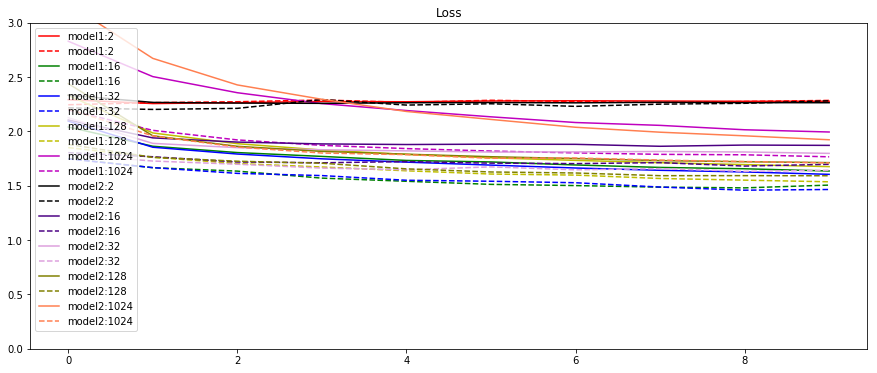

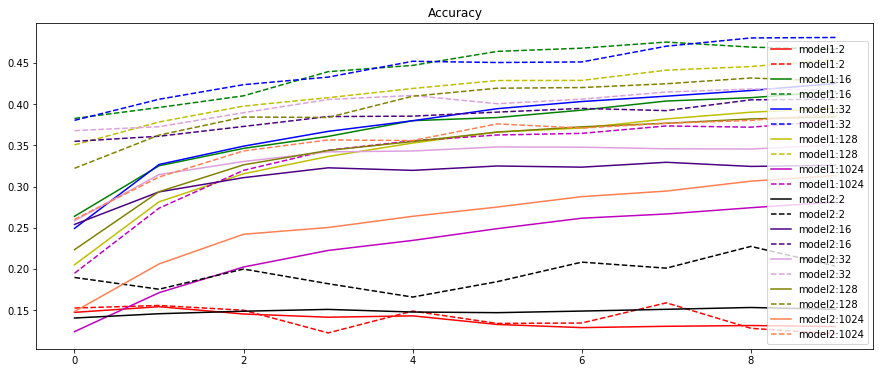

In [27]:
import matplotlib.pyplot as plt
%matplotlib inline
"""Code Here
將結果繪出
"""
color_bar = ["r", "g", "b", "y", "m", "k", 'indigo', 'plum', 'olive', 'coral']

plt.figure(figsize=(15,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train_loss'])),results[cond]['train_loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid_loss'])),results[cond]['valid_loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 3])
plt.legend()
plt.show()

plt.figure(figsize=(15,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train_acc'])),results[cond]['train_acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid_acc'])),results[cond]['valid_acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()
